# Установка библиотек


In [ ]:
# Grab Jaime's excellent condacolab package: https://github.com/jaimergp/condacolab
# Note: you should probably read the README file at that repo.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -c conda-forge rdkit chembl_structure_pipeline



                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit', 'chembl_structure_pipeline']

conda-forge/linux-64     Using cache
conda-forge/noarch     

In [ ]:
!git clone https://github.com/DSPsleeporg/smiles-transformer.git

fatal: destination path 'smiles-transformer' already exists and is not an empty directory.


# Импорт библиотек

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import NearestNeighbors

sys.path.append('./smiles-transformer/smiles_transformer')

import torch
from pretrain_trfm import TrfmSeq2seq
from build_vocab import WordVocab
from utils import split


from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

# Utils

Создадим функции для обработки данных

In [ ]:
# Функция принимает на вход один SMILES, укорачивает их
# При помощи словаря переводит символы в набор цифр
# Возвращает массив чисел
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids) 
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids

# Функция принимает на вход набор SMILES
# И применяет функцию get_inputs()
def get_array(smiles):
    x_id = []
    for sm in smiles:
        a = get_inputs(sm)
        x_id.append(a)
        
    return torch.tensor(x_id)

In [ ]:
# функция отрисовки красивых молекул
def plot_mols(mols, unit=200, w=120, h=200, fontsize=1.0):
    drawer = Draw.MolDraw2DSVG(4*unit, 3*unit, w, h)

    opt = drawer.drawOptions()
    opt.padding = 0.1
    opt.legendFontSize = 20


    xs = np.array([0,1,2,3,0,1,2,3,0,1,2,3])*unit
    ys = np.array([0,0,0,0,1,1,1,1,2,2,2,2])*unit
    for i, (mol, x, y) in enumerate(zip(mols,xs,ys)):

        drawer.SetOffset(int(x), int(y))
        drawer.SetFontSize(fontsize)

        AllChem.Compute2DCoords(mol)
        Chem.Kekulize(mol)

        drawer.DrawMolecule(mol, legend=str(i))



    drawer.FinishDrawing()
    return drawer

# Предобученная модель

Как показал наш опыт работы с текстовыми моделями, получить хороший скор, имея на руках небольшой корпус текстов (всего несколько тысяч SMILES) - задача непростая :(

Одиночные блоки  RNN и LSTM не могут вытащить достаточно информации для хороших предсказаний.

При этом измерить в лаборатории молекулярные свойста для большого числа молекул - дорогой по времени и материалам процесс.



Что же делать?

Есть датасеты известных молекул состоящие из миллионов объектов. Один из таких корпусов - [ChemBL database](https://www.ebi.ac.uk/chembl/).

Что если мы попробуем вытащить скрытые свойства молекул имея на руках только SMILES, не используя предсказания растворимости?


Это делается при помощи моделей автоэнкодеров.

![](https://sun9-69.userapi.com/impg/apo1uut5kWtKKeuCJHQT49z4VrcyZLUwH-yPXw/Q7V_OFqiy0Y.jpg?size=1406x976&quality=96&sign=48e376482628d4fd8f61472253d40992&type=album)

Автоэнкодер принимает на вход молекулу, после серии преобразований сворачивает ее в вектор небольшой размерности, затем пытается из этого вектора предсказать исходное представление молекулы!

Если у него это выходит - значит, "скрытое" представление содержит достаточно признаков, которые отвечают за представление молекулы.

Теперь можно взять из обученной модели только ту часть, которая вытаскивает свойства молекулы (энкодер) и на этих векторах сделать свои предсказания!

## Transformer

### В моделях, работающих с естественным языком SOTA моделями являются ***трансформеры***.

Трансформеры включают в себя слои Attention - это слои, которые сохраняют дополнительную информацию о слове, которое они обрабатывают. Когда мы читаем предложения в тексте - мы обращаем внимание на конкретные слова. Attention реализуют внутри себя эту функцию. Передавая "важность" слова между слоями мы можем улучшить наши предсказания.

![](https://miro.medium.com/max/1200/1*KD1xANybFo4EC2V2unn3RQ.gif)

Трансформер состоит из нескольких блоков, включающих слои Attention.

![](https://miro.medium.com/max/1400/1*V2435M1u0tiSOz4nRBfl4g.png)

# План 

1. Загрузим предобученную модель трансформера
2. Вытащим вектора признаков молекул
3. Построим предсказания
4. Визуализируем полученные вектора

# Загрузка модели

In [ ]:
# Загружаем словарь символы-номера символов
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/vocab.pkl

--2021-05-09 10:24:29--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/vocab.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/vocab.pkl [following]
--2021-05-09 10:24:30--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/vocab.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1723 (1.7K) [application/octet-stream]
Saving to: ‘vocab.pkl’

vocab.pkl           100%[===================>]   1.68K  --.-KB/s    in 0s      

2021-05-09 10:24:30 (26.8 MB/s) - ‘vocab.pkl’ saved [1723/1723]



In [ ]:
# загрузим веса предобученной модели
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/weights_trfm.pkl

--2021-05-09 10:25:07--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/weights_trfm.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/weights_trfm.pkl [following]
--2021-05-09 10:25:08--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/weights_trfm.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22128521 (21M) [application/octet-stream]
Saving to: ‘weights_trfm.pkl’

weights_trfm.pkl    100%[===================>]  21.10M  34.0MB/s    in 0.6s    

2021-05-09 10:25:09 (34.0 MB/s) - ‘wei

In [ ]:
pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4#??????

In [ ]:
vocab = WordVocab.load_vocab('vocab.pkl')

Теперь создадим модель трансформера

**TO-DO**
1. Создайте модель TrfmSeq2seq. На вход она принимает 4 параметра, определяющих архитектуру модели: len(vocab), 256, len(vocab), 4
2. Загрузите веса в полученную модель при помощи метода load_state_dict и функции torch.load (если запускаете на cpu, добавьте в torch.load аргумент map_location=torch.device('cpu'))
3. Мы не будем тренировать модель. Включите у модели метод eval()

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4) #??
trfm.load_state_dict(torch.load("weights_trfm.pkl", map_location=torch.device('cpu')))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

Total parameters: 4245037


Загрузим наши данные

In [ ]:
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/esol.csv

--2021-05-09 10:25:39--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/esol.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/esol.csv [following]
--2021-05-09 10:25:39--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/esol.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘esol.csv’

esol.csv            100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2021-05-09 10:25:40 (6.29 MB/s) - ‘esol.csv’ saved [96699/96699]



In [ ]:
data = pd.read_csv('esol.csv')

**TO-DO**
1. Примените функцию split(sm) ко всем smiles из датасета
2. Используйте функцию get_array на полученных данных x_split



In [ ]:
data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [ ]:
from multiprocess import Pool
with Pool(10) as pool:
    x_split = data.smiles.apply(split)
xid = get_array(x_split)

In [ ]:
type(x_split)

pandas.core.series.Series

Имея на руках SMILES, переведенные в наборы цифр, можем получить свойства молекул из нашей модели.

**TO-DO**
1. Используйте метод encode() модели для получения векторов . Не забудьте сделать torch.Tensor из xid!

In [ ]:
X_esol = trfm.encode(torch.t(xid))
print(X_esol.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [ ]:
X_esol.shape

(1128, 1024)

In [ ]:
from sklearn.model_selection import train_test_split
def evaluate_regression(X, y, model='ridge'):
    if model=='ridge':
        reg = Ridge()
    elif model=='rf':
        reg = RandomForestRegressor(n_estimators=10)
    else:
        raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))

    # разделите данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
    # примените модель reg к тренировочным данным
    reg.fit(X_train, y_train)

    # сделайте предсказания на тестовой выборке
    y_pred = reg.predict(X_test)

    # посчитайте rmse и r2 для предсказаний
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    ret = {}
    ret['r2'] = r2

    ret['rmse'] = rmse

    return ret

In [ ]:
score_dic_esol = evaluate_regression(X_esol, data['measured log solubility in mols per litre'].values, model='rf')
print(score_dic_esol)

{'r2': 0.8088886882286552, 'rmse': 0.9336278149633055}


Теперь давайте попробуем применить этот подхрод к датасету Lipophilicity!

In [ ]:
!wget https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/lipophilicity.csv


--2021-05-09 10:27:05--  https://github.com/kostyastrong/HSE_nlp_mol_properties/raw/master/data/lipophilicity.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/lipophilicity.csv [following]
--2021-05-09 10:27:05--  https://raw.githubusercontent.com/kostyastrong/HSE_nlp_mol_properties/master/data/lipophilicity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282606 (276K) [text/plain]
Saving to: ‘lipophilicity.csv’

lipophilicity.csv   100%[===================>] 275.98K  --.-KB/s    in 0.03s   

2021-05-09 10:27:05 (8.28 MB/s) - ‘lipophilicity.

**TO-DO**

1. Закодируйте smiles датасета в числовые последовательности
2. Примените модель трансформера для получения векторов свойств молекул
3. Посчитайте модель регрессии на полученных векторах

In [ ]:
data_lip = pd.read_csv('lipophilicity.csv')
x_split_lip = data_lip.smiles.apply(split)
xid_lip = get_array(x_split_lip)

SMILES is too long (251)
SMILES is too long (267)


In [ ]:
X_lip = trfm.encode(torch.t(xid_lip))
print(X_lip.shape)

There are 4200 molecules. It will take a little time.
(4200, 1024)


In [ ]:
score_dic_lip = evaluate_regression(X_lip, data_lip['exp'].values, model='rf')
print(score_dic_lip)

{'r2': 0.3037624976560568, 'rmse': 1.0177521274146977}


 Ой-ой...
 Что не так?

 Интерпретация моделей глубокого обучения - сложная тема. Существует множество методов, как понять, поняла ли нейросеть что-то из данных.

 Давайте попробуем нарисовать свойства, которые модель получила для наших датасетов и сравним.

# Визуализация

Для отрисовки векторов большого размера на плоскости мы будем использовать функцию tsne. Эта функция пытается сопоставить каждому вектору большого пространства вектор на плоскости так, чтобы близкие вектора из большого пространства были близкими на плоскости - и наоборот.

In [ ]:
from sklearn.manifold import TSNE

 **TO-DO**

 1. создайте объект TSNE. В качестве параметров передайте размерность пространства, которую мы хотим получить на выходе.
 2. Примените метод fit_transform к векторам, полученным из трансформера.
 3. Вытащите целевую переменную
 

In [ ]:
data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [ ]:
ts = TSNE(2)
X_esol_reduced = ts.fit_transform(X_esol)
y_esol = data['measured log solubility in mols per litre']

Отрисуем полученные вектора

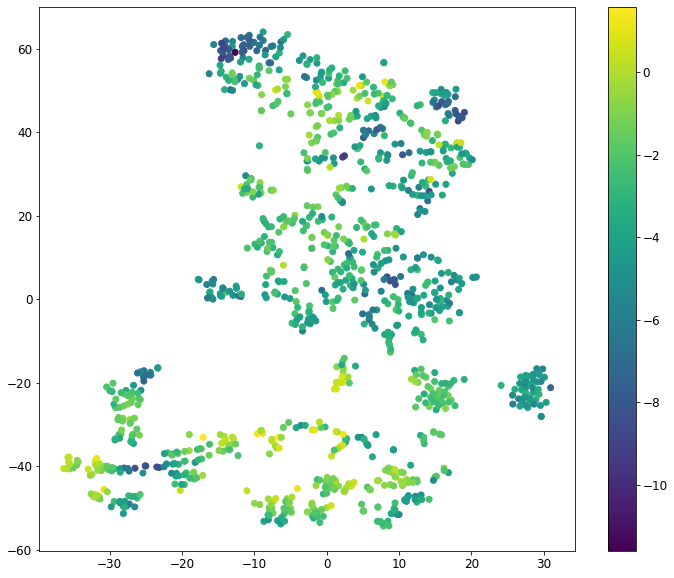

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = 12
plt.scatter(X_esol_reduced[:, 0], X_esol_reduced[:, 1], c=y_esol, marker='o')
plt.colorbar()
plt.show()

**TO-DO**

Сделайте визуализацию для датасета Lipophilicity

In [ ]:
ts = TSNE(2)
X_lip_reduced = ts.fit_transform(X_lip)
y_lip = data_lip.exp

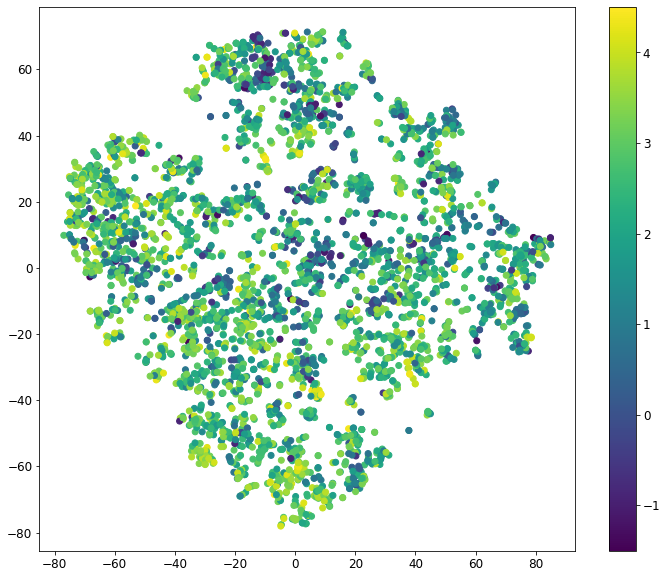

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = 12
plt.scatter(X_lip_reduced[:, 0], X_lip_reduced[:, 1], c=y_lip, marker='o')
plt.colorbar()
plt.show()

Посмотрим, что за молекулы нарисованы на плоскости.

Выберем последовательность находящихся рядом молекул.
Для этого используем модель, которая подбирает ближайших соседей к точке

**TO-DO**:
1. Создайте объект NearestNeighbors, передайте аргумент metric='euclidean' (считаем расстояние по как евклидово)
2. Примените модель к X_esol_reduced (fit)
3. Задайте область, в которой будем искать соседей при помощи np.linspace (на вход принимает начало области по оси, конец области и количество точек). Размер области посмотрите по картинке с отрисованными векторами.

In [ ]:
nn = NearestNeighbors(metric='euclidean')
nn.fit(X_esol_reduced)

xs = np.linspace(-60, 50, 12)
ys = np.linspace(-60, 60, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_esol_reduced[result[0, 0]])
pts = np.array(pts)

  0%|          | 0/1128 [1:03:10<?, ?it/s]


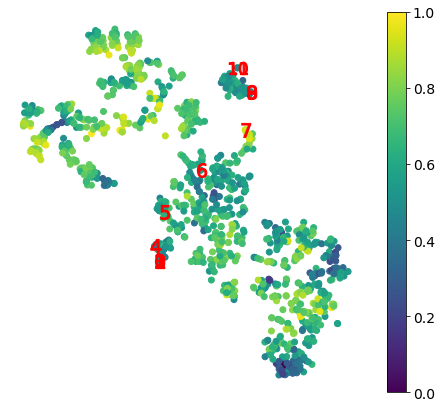

In [ ]:

fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.axis('off')
plt.scatter(X_esol_reduced[:, 0], X_esol_reduced[:, 1], c=data['measured log solubility in mols per litre'].values, marker='o')
for i in range(12):
    plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.colorbar()
plt.savefig('esol.png', dpi=300)
plt.show()

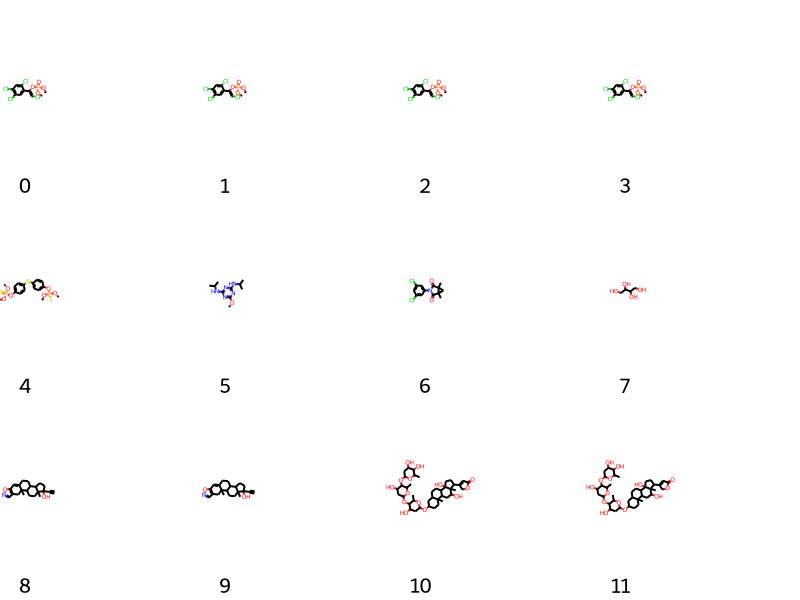

In [ ]:
from IPython.display import SVG
mols = [Chem.MolFromSmiles(sm) for sm in data['smiles'].values[ids]]
dr = plot_mols(mols, w = 50)
with open('esol.svg', 'w') as f:
    f.write(dr.GetDrawingText())
SVG(dr.GetDrawingText())

Что вы видите на получившейся картинке?